#**MAJOR PROJECT - SIGN LANGUAGE RECOGNITION USING DEEP LEARNING AND COMPUTER VISION**

Done By:
*   Arushi Shree Manoj - 23201012023
*   Sona Antony - Roll No.
*   Venkata Shreya Jakkinapalli - 22101012022






STEP-1:Installing necessary Libraries and Packages
*   tensorflow: for training and inference of deep neural networks.
*   numpy: numerical operations and array handling.
*   cv2: part of the OpenCV Library for computer vision tasks. Used in our project to read images from files and preprocess tasks like normalization and data augmentation.
*   matplotlib: plotting and visualization
*   opencv-python-headless: ideal for cloud-based environments where graphical interfaces are not available. Also for image reading, writing and processing without needing display functionalities.








In [1]:
#importing libraries and packages
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
!pip install tensorflow opencv-python-headless matplotlib
from sklearn.model_selection import train_test_split
import os

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip sign-language-mnist.zip
import pandas as pd
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

#the next few lines were used to extract and prepare the features and labels from the training and testing datasets.
#iloc is a pandas indexing method used to select specific rows and columns from the data frame.
x_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
x_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 75% 47.0M/62.6M [00:00<00:00, 85.2MB/s]
100% 62.6M/62.6M [00:00<00:00, 85.8MB/s]
Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [3]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Unique values in y_test: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


STEP-2: Data Preprocessing
*   Reshaping: helps nump to infer the number of samples based on original array's size and the specified dimensions. And the number of color channels have been kept to 1 by grayscaling.
*   Normalization: Pixel Values are typically in the range of 0 to 255. Hence by dividing it with 255, we are bringing to  range of 0 to 1, thereby improving the training stability and performane of the neural network.



In [4]:
x_train = x_train.reshape(-1,28,28,1)/255.0
x_test = x_test.reshape(-1,28,28,1)/255.0
num_classes = 25
y_train = tf.keras.utils.to_categorical(y_train,num_classes = num_classes)
y_test = tf.keras.utils.to_categorical(y_test,num_classes = num_classes)

In [5]:
#Checking number of images for every class in both training and testing to see if there is a slight data imbalance that can potentially cause issues in the future training and prediction
from collections import defaultdict
def count_images_from_csv(csv_path):
  df = pd.read_csv(csv_path)
  class_counts = defaultdict(int)
  for _, row in df.iterrows():
    class_name = row['label']
    class_counts[class_name]+=1
  print("Class counts:")
  for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")
train_csv_path = '/content/sign_mnist_train/sign_mnist_train.csv'
test_csv_path = '/content/sign_mnist_train/sign_mnist_train.csv'
print("Training set: ")
count_images_from_csv(train_csv_path)
print("\nTesting set:")
count_images_from_csv(test_csv_path)

Training set: 
Class counts:
3: 1196 images
6: 1090 images
2: 1144 images
13: 1151 images
16: 1279 images
8: 1162 images
22: 1225 images
18: 1199 images
10: 1114 images
20: 1161 images
17: 1294 images
19: 1186 images
21: 1082 images
23: 1164 images
24: 1118 images
1: 1010 images
12: 1055 images
11: 1241 images
15: 1088 images
4: 957 images
0: 1126 images
5: 1204 images
7: 1013 images
14: 1196 images

Testing set:
Class counts:
3: 1196 images
6: 1090 images
2: 1144 images
13: 1151 images
16: 1279 images
8: 1162 images
22: 1225 images
18: 1199 images
10: 1114 images
20: 1161 images
17: 1294 images
19: 1186 images
21: 1082 images
23: 1164 images
24: 1118 images
1: 1010 images
12: 1055 images
11: 1241 images
15: 1088 images
4: 957 images
0: 1126 images
5: 1204 images
7: 1013 images
14: 1196 images


Class count in training data: 
label
17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: count, dtype: int64


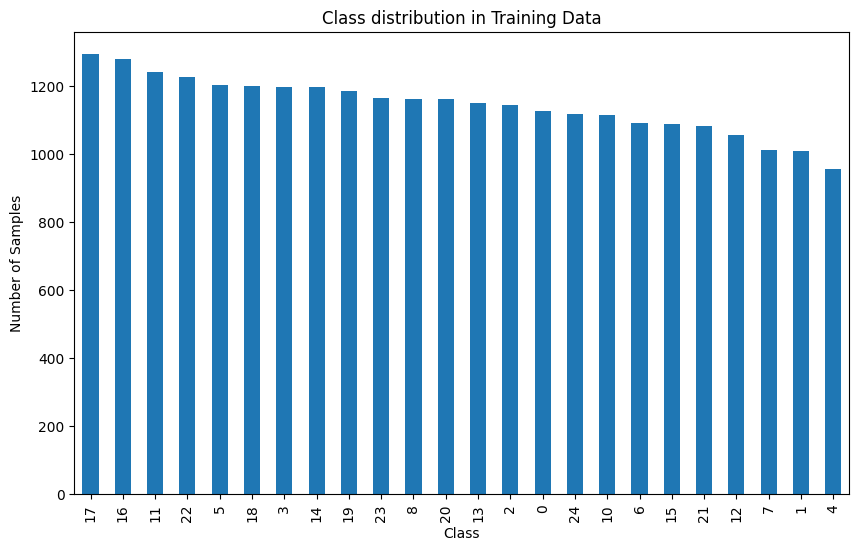

In [6]:
import pandas as pd
#trying to understand if there is a class imbalnce to prevent model from being biased towards the more frequent classes
train_df = pd.read_csv('sign_mnist_train.csv')
class_counts = train_df['label'].value_counts()
print("Class count in training data: ")
print(class_counts)
plt.figure(figsize = (10,6))
class_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class distribution in Training Data')
plt.show()


The results were:
*   The number of images per class in training and testing were falling in the range of 900-1300, fairly decent.
*   However, to prevent it from causing a model performance issue, we added class weights to help the model we trained learn better representations for the minority classes.
*  We also performed Data augmentation technique to artificially generate new data from existing data to increase data variation and possibly help the model improve the accuracy of its predictions.






In [7]:
#handling the case of slightly imbalanced dataset. By attempting to adjust the weights, we aim to ensure the model is able to learn from each more effectively.
#compute_class_weightis the function that calculates weights for each class to balance the class distribution.
from sklearn.utils import class_weight
import numpy as np
cWts = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(train_df['label']),
    y=train_df['label']
)
cWts_dict = dict(enumerate(cWts))
print("Class Weight: ")
print(cWts_dict)

Class Weight: 
{0: 1.0159487862640615, 1: 1.1326320132013201, 2: 0.999963578088578, 3: 0.956486900780379, 4: 1.1953587600139324, 5: 0.9501315060908084, 6: 1.0495030581039755, 7: 1.129277722935176, 8: 0.9844736087205966, 9: 1.026892579293836, 10: 0.9218036529680366, 11: 1.0843206951026856, 12: 0.9938821314798726, 13: 0.956486900780379, 14: 1.0514322916666667, 15: 0.8944162105811833, 16: 0.8840481710458526, 17: 0.9540936891854324, 18: 0.9645517144463182, 19: 0.9853215618719494, 20: 1.057262784966112, 21: 0.933843537414966, 22: 0.9827820733104238, 23: 1.0232185450208706}


Training the CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

*   Each image is 28X28 pixels with 1 color channel (grayscale).
*   ReLU is a nonlinear activation function that's often used in deep learning and machine learning. It mitigates the vanishing gradient problem during machine learning model training and enabling neural networks to learn more complex relationships in data. it also trains faster.
*   Maxpooling reduces the height and width of an image by taking the maximum values of every 2x2 Block.
*   Flatten: this was done to convert the 2D Feature maps into a 1D vector.
*   Dense: this layers learns complex representations of the features extracted by the convolutional layers.
*   Dropout Regularization: This is done inorder to prevent overfitting. Hence by randomly choosing to drop a part of the neurons during the training phase, the model learn to perform on new and usneen data.








In [9]:
model = Sequential ([
    Input(shape = (28,28,1)),
    Conv2D(32,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(64,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128,activation = 'relu'),
    Dropout(0.5),
    Dense(num_classes,activation = 'softmax')
])
#compiling the model
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,969 (886.60 KB)

 Trainable params: 226,969 (886.60 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    x_train,y_train,
    epochs = 10,
    batch_size = 32,
    validation_data = (x_test,y_test),
    class_weight = {0: 1.0159487862640615, 1: 1.1326320132013201, 2: 0.999963578088578, 3: 0.956486900780379, 4: 1.1953587600139324, 5: 0.9501315060908084, 6: 1.0495030581039755, 7: 1.129277722935176, 8: 0.9844736087205966, 9: 1.026892579293836, 10: 0.9218036529680366, 11: 1.0843206951026856, 12: 0.9938821314798726, 13: 0.956486900780379, 14: 1.0514322916666667, 15: 0.8944162105811833, 16: 0.8840481710458526, 17: 0.9540936891854324, 18: 0.9645517144463182, 19: 0.9853215618719494, 20: 1.057262784966112, 21: 0.933843537414966, 22: 0.9827820733104238, 23: 1.0232185450208706}
)

Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 68s 70ms/step - accuracy: 0.2982 - loss: 2.3185 - val_accuracy: 0.8394 - val_loss: 0.5349
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - accuracy: 0.8126 - loss: 0.5439 - val_accuracy: 0.9105 - val_loss: 0.2824
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 50ms/step - accuracy: 0.8939 - loss: 0.3013 - val_accuracy: 0.9172 - val_loss: 0.2507
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9312 - loss: 0.2010 - val_accuracy: 0.9370 - val_loss: 0.2111
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9452 - loss: 0.1562 - val_accuracy: 0.9338 - val_loss: 0.1769
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.9581 - loss: 0.1203 - val_accuracy: 0.9382 - val_loss: 0.1796
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.9667 - loss: 0.0985 - val_accuracy: 0.9455 - val_loss: 0.1750
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - accuracy: 0.9694 - loss: 0.0868 - 

In [11]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9482 - loss: 0.1678
Test Accuracy: 0.947016179561615


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9482 - loss: 0.1678


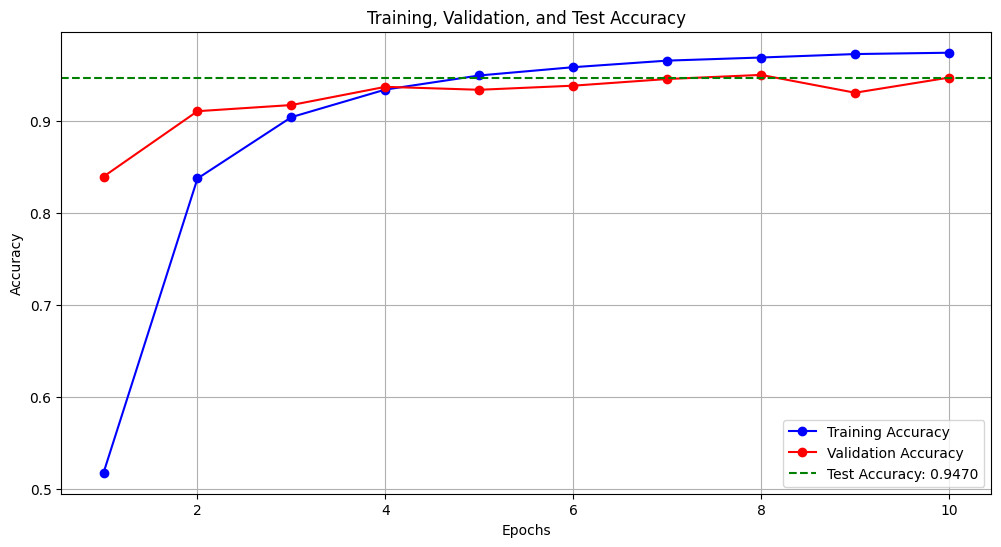

In [12]:
#plotting a line plot/line graph
# to display accuracy of the training and validation accuracy of the model changes over epochs during this training and validation phase.
#Each line on the plot depicts a collection of data points connected in sequence.
epochs = range(1,len(history.history['accuracy'])+1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_loss,test_accuracy = model.evaluate(x_test,y_test)
plt.figure(figsize = (12,6))
plt.plot(epochs,train_accuracy,'bo-', label='Training Accuracy')
plt.plot(epochs,val_accuracy,'ro-', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label = f'Test Accuracy: {test_accuracy:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The results we obtained from here show that as the training and validation accuracy are both high and do not have a large gap in difference of values, this is a positive indicator of not being overfitted.

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


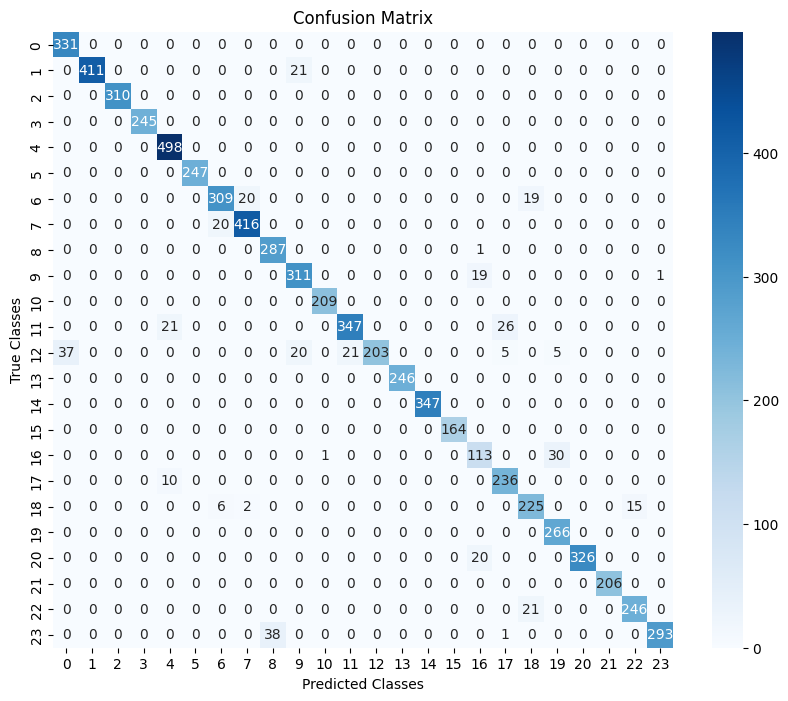

In [14]:
#Plotting the confusion matrix to get a better idea of which all classes are being predicted correctly, and whicha re getting classified incorrectly
#np.argmax from the numpy library returns the indices of the maximum values along the data. This gives the predicted class labels for each sample.
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1)
confMatrix = confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix,annot = True, fmt='d',cmap='Blues')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()

The results were:
*   the diagonal Values represent the true positive counts (i,i) - it shows how many times it predicted that particular alphabet correctly.
*   the off-diagonal values represent misclassifications. values not on the diagonal indicate how often predictions for one class were mistaken for another class.



In [15]:
model.save('sign_language_model.h5')

Inference of the trained CNN Model on the images uploaded by the user
*   Model prediction through class label mapping to the index of the highest probability and corresponding visualization through image display
*   Images were prepared for model input, and displaying images and predictions to the users.



Saving o.jpg to o (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


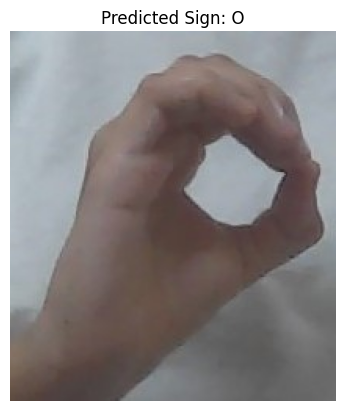

In [26]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image

model = load_model('sign_language_model.h5')
class_labels = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P',
    16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'

}
uploaded = files.upload()
for fn in uploaded.keys():
  if fn.lower().endswith(('.png', '.jpg','.jpeg', '.bmp', '.gif')):
    img = load_img(fn, target_size = (28,28), color_mode = "grayscale")
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array,axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction,axis=1)[0]
    label = class_labels.get(predicted_class, 'Unknown')
    original_img = Image.open(fn)
    plt.imshow(original_img)
    plt.title(f'Predicted Sign: {label}')
    plt.axis('off')
    plt.show()
  else:
    print(f"File{fn} is not an image.")

In [17]:
class_labels = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q',
    16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y',
}

Accuracy for class A: 1.00
Accuracy for class B: 0.95
Accuracy for class C: 1.00
Accuracy for class D: 1.00
Accuracy for class E: 1.00
Accuracy for class F: 1.00
Accuracy for class G: 0.89
Accuracy for class H: 0.95
Accuracy for class I: 1.00
Accuracy for class K: 0.94
Accuracy for class L: 1.00
Accuracy for class M: 0.88
Accuracy for class N: 0.70
Accuracy for class O: 1.00
Accuracy for class P: 1.00
Accuracy for class Q: 1.00
Accuracy for class R: 0.78
Accuracy for class S: 0.96
Accuracy for class T: 0.91
Accuracy for class U: 1.00
Accuracy for class V: 0.94
Accuracy for class W: 1.00
Accuracy for class X: 0.92
Accuracy for class Y: 0.88


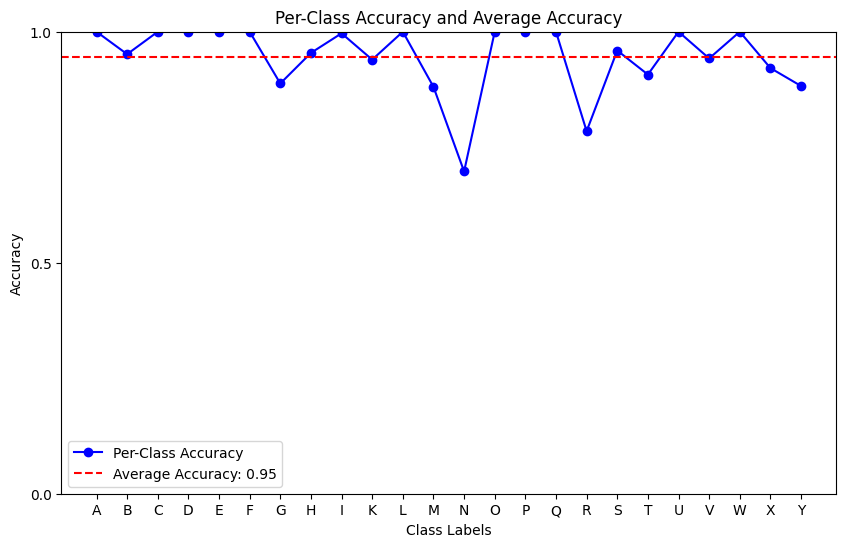

In [18]:
per_class_accuracy = {}
for i in range(0,24):
  per_class_accuracy[class_labels[i]] = confMatrix[i,i]/np.sum(confMatrix[i])
for class_label, accuracy in per_class_accuracy.items():
  print(f'Accuracy for class {class_label}: {accuracy:.2f}')

average_accuracy = np.mean(list(per_class_accuracy.values()))

# Plotting the per-class accuracy
plt.figure(figsize=(10, 6))
plt.plot(list(per_class_accuracy.keys()), list(per_class_accuracy.values()), marker='o', linestyle='-', color='b', label='Per-Class Accuracy')
plt.axhline(y=average_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {average_accuracy:.2f}')

plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.yticks(np.arange(0, 1.25, 0.50))  # Set the y-axis ticks with a unit of 0.25

# Adding labels and title
plt.xlabel('Class Labels')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy and Average Accuracy')
plt.legend()

# Show plot

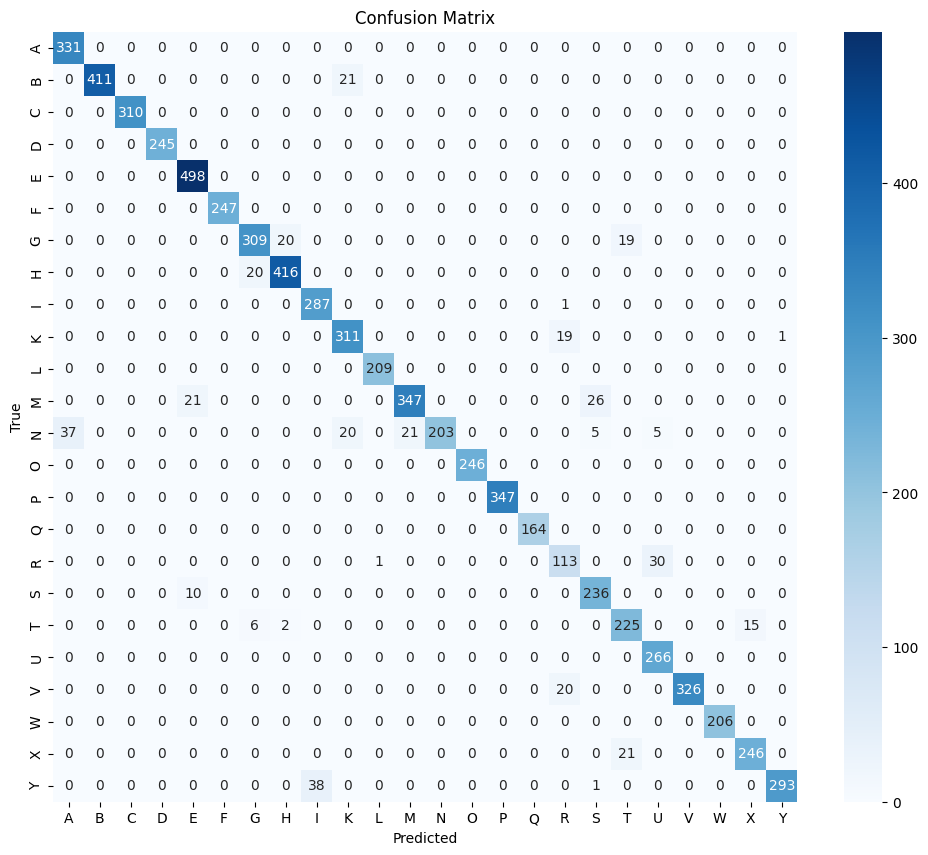

In [19]:
num_classes = 24
confMatrix1 = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(confMatrix1, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_labels[i] for i in range(num_classes)],
            yticklabels=[class_labels[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Average Accuracy: 0.95
Average Precision: 0.95
Average Recall: 0.95
Average F1 Score: 0.94
Metrics for class A:
  Accuracy: 1.00
  Precision: 0.90
  Recall: 1.00
  F1 Score: 0.95
Metrics for class B:
  Accuracy: 0.95
  Precision: 1.00
  Recall: 0.95
  F1 Score: 0.98
Metrics for class C:
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00
Metrics for class D:
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00
Metrics for class E:
  Accuracy: 1.00
  Precision: 0.94
  Recall: 1.00
  F1 Score: 0.97
Metrics for class F:
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00
Metrics for class G:
  Accuracy: 0.89
  Precision: 0.92
  Recall: 0.89
  F1 Score: 0.90
Metrics for class H:
  Accuracy: 0.95
  Precision: 0.95
  Recall: 0.95
  F1 Score: 0.95
Metrics for class I:
  Accuracy: 1.00
  Precision: 0.88
  Recall: 1.00
  F1 Score: 0.94
Metrics for class K:
  Accuracy: 0.94
  Precision: 0.88
  Recall: 0.94
  F1 Score: 0.91
Metrics for class L:
  Accura

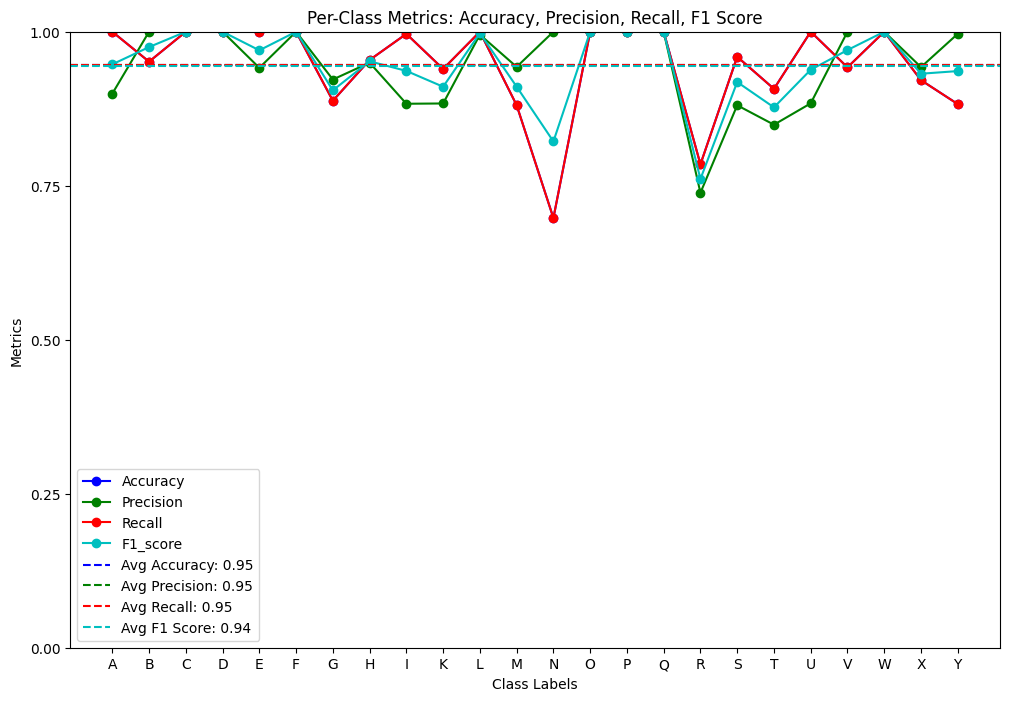

In [20]:
import numpy as np
num_classes = 24
# Calculate per-class accuracy, precision, recall, and F1 score
per_class_metrics = {}
tot_accuracy = 0
tot_precision = 0
tot_recall = 0
tot_f1score = 0
for i in range(num_classes):
    true_class_count = np.sum(confMatrix1[i])
    correct_predictions = confMatrix1[i, i]
    accuracy = correct_predictions / true_class_count
    true_positive = correct_predictions
    false_positive = np.sum(confMatrix1[:, i]) - true_positive
    false_negative = true_class_count - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    per_class_metrics[class_labels[i]] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }
    tot_accuracy += accuracy
    tot_precision += precision
    tot_recall += recall
    tot_f1score += f1_score

avg_accuracy = tot_accuracy / num_classes
avg_precision = tot_precision / num_classes
avg_recall = tot_recall / num_classes
avg_f1_score = tot_f1score / num_classes

# Print the average metrics
print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1 Score: {avg_f1_score:.2f}")
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
colors = ['b', 'g', 'r', 'c']
plt.figure(figsize=(12, 8))

for class_label, metrics in per_class_metrics.items():
    print(f"Metrics for class {class_label}:")
    print(f"  Accuracy: {metrics['accuracy']:.2f}")
    print(f"  Precision: {metrics['precision']:.2f}")
    print(f"  Recall: {metrics['recall']:.2f}")
    print(f"  F1 Score: {metrics['f1_score']:.2f}")

for idx, metric in enumerate(metrics):
    plt.plot(list(per_class_metrics.keys()),
             [per_class_metrics[class_label][metric] for class_label in class_labels.values()],
             marker='o', linestyle='-', color=colors[idx], label=metric.capitalize())

plt.axhline(y=avg_accuracy, color='b', linestyle='--', label=f'Avg Accuracy: {avg_accuracy:.2f}')
plt.axhline(y=avg_precision, color='g', linestyle='--', label=f'Avg Precision: {avg_precision:.2f}')
plt.axhline(y=avg_recall, color='r', linestyle='--', label=f'Avg Recall: {avg_recall:.2f}')
plt.axhline(y=avg_f1_score, color='c', linestyle='--', label=f'Avg F1 Score: {avg_f1_score:.2f}')


# Customizing the y-axis
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.yticks(np.arange(0, 1.25, 0.25))  # Set the y-axis ticks with a unit of 0.25

# Adding labels, title, and legend
plt.xlabel('Class Labels')
plt.ylabel('Metrics')
plt.title('Per-Class Metrics: Accuracy, Precision, Recall, F1 Score')
plt.legend()

# Show plot
plt.show()



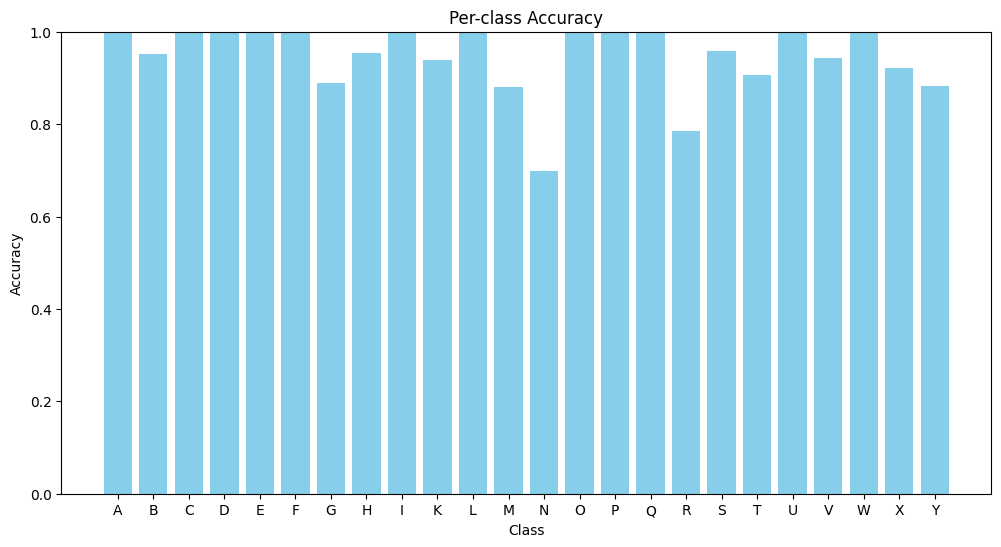

In [21]:
labels = list(per_class_metrics.keys())
accuracies = [metrics['accuracy'] for metrics in per_class_metrics.values()]
plt.figure(figsize = (12,6))
plt.bar(labels,accuracies,color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-class Accuracy')
plt.ylim([0,1])
plt.show()

Applying Data Augmentation and retraining the model to see if it improves accuracy

In [28]:
#the ImageDatGenerator class in Keras is used for real-time data augmentation, which was used to generalize our model by introducing variations to it.
#the iamges were rotated by a certain range of degrees only, inorder to make the model invariant to slight rotations.
#horizontal shifts were made to simulate the different horizontlal positions
#shear: slanting the image along a particular axis, to make it more diverse to distortions
#images have been zoomed in and out to simulate the different scales of he object.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen.fit(x_train)
history_aug = model.fit(datagen.flow(x_train, y_train, batch_size = 32), epochs=15, validation_data = (x_test,y_test))


Epoch 1/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 59s 64ms/step - accuracy: 0.1050 - loss: 2.9810 - val_accuracy: 0.8109 - val_loss: 0.8194
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - accuracy: 0.4544 - loss: 1.6622 - val_accuracy: 0.8848 - val_loss: 0.5371
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 85s 66ms/step - accuracy: 0.5632 - loss: 1.3254 - val_accuracy: 0.9028 - val_loss: 0.4735
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.6052 - loss: 1.1860 - val_accuracy: 0.8795 - val_loss: 0.4447
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.6375 - loss: 1.0815 - val_accuracy: 0.9243 - val_loss: 0.3493
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 78s 63ms/step - accuracy: 0.6566 - loss: 1.0152 - val_accuracy: 0.9293 - val_loss: 0.3433
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 85s 67ms/step - accuracy: 0.6729 - loss: 0.9657 - val_accuracy: 0.9375 - val_loss: 0.3078
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.6911 - loss: 0.9081 - 

The results from this were:
*   Although we applied dat augmentation, the results weren't fruitful in generating a higher accuracy.



225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9571 - loss: 0.1829


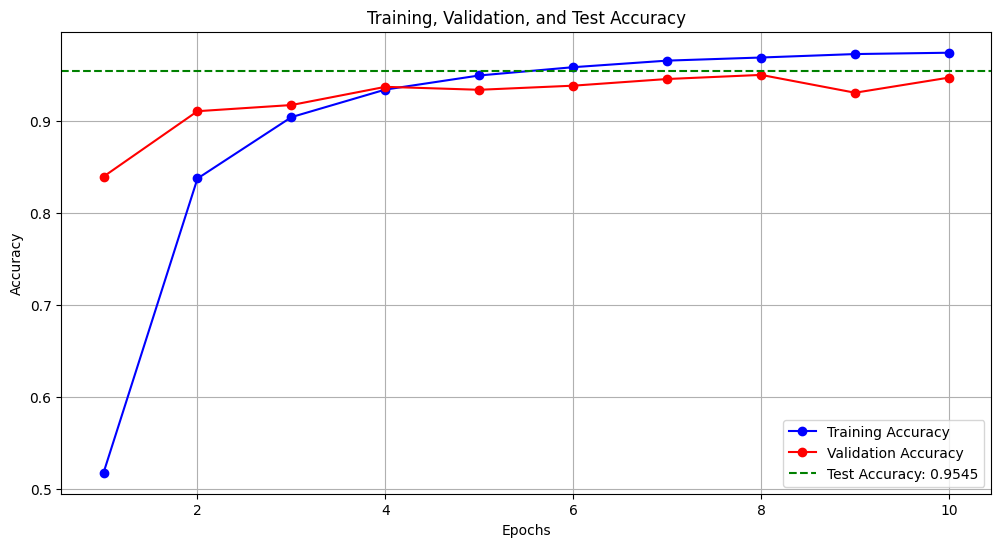

In [29]:
epochs = range(1,len(history.history['accuracy'])+1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_loss,test_accuracy = model.evaluate(x_test,y_test)
plt.figure(figsize = (12,6))
plt.plot(epochs,train_accuracy,'bo-', label='Training Accuracy')
plt.plot(epochs,val_accuracy,'ro-', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label = f'Test Accuracy: {test_accuracy:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
model.save('sign_language_model_augmented.h5')

Saving r.jpg to r (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


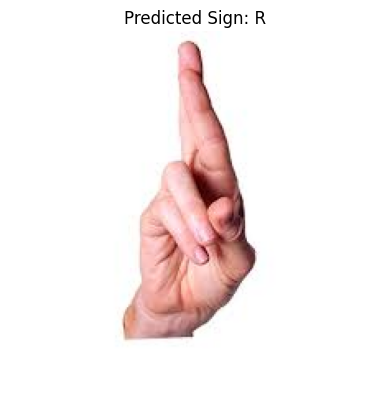

In [31]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image

model = load_model('sign_language_model_augmented.h5')
class_labels = {
 0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P',
    16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
}
uploaded = files.upload()
for fn in uploaded.keys():
  if fn.lower().endswith(('.png', '.jpg','.jpeg', '.bmp', '.gif')):
    img = load_img(fn, target_size = (28,28), color_mode = "grayscale")
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array,axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction,axis=1)[0]
    label = class_labels.get(predicted_class, 'Unknown')
    original_img = Image.open(fn)
    plt.imshow(original_img)
    plt.title(f'Predicted Sign: {label}')
    plt.axis('off')
    plt.show()
  else:
    print(f"File{fn} is not an image.")